# Data Preprocessing

Joeri R. Hermans                    
*Departement of Data Science & Knowledge Engineering*          
*Maastricht University, The Netherlands*           

In this notebook we mainly deal with the preprocessing of the physics data that we processed into a more managable format in the Data Extraction notebook. We prepare them in such a way that they are ready for ML problems. Furthermore, in order to have complete information at a later stage, we maintain the "old" information as well. This includes all the extracted parameters of the tracks that have been reconstructed by offline software.

## Cluster Configuration

In the following sections, we set up the cluster properties in order to preprocess the tracks dataset.

In [1]:
%matplotlib inline

import numpy as np

import os

from pyspark import SparkContext
from pyspark import SparkConf

from pyspark.storagelevel import StorageLevel

from pyspark.sql import Row
from pyspark.sql.types import *

import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

# Use the DataBricks AVRO reader.
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages com.databricks:spark-avro_2.11:3.2.0 pyspark-shell'

In [2]:
# Modify these variables according to your needs.
application_name = "CMS Track Preprocessing"
using_spark_2 = False
local = False
path_data = "data/tracks.avro"

if local:
    # Tell master to use local resources.
    master = "local[*]"
    num_processes = 3
    num_executors = 1
else:
    # Tell master to use YARN.
    master = "yarn-client"
    num_executors = 20
    num_processes = 4

# This variable is derived from the number of cores and executors,
# and will be used to assign the number of model trainers.
num_workers = num_executors * num_processes

print("Number of desired executors: " + `num_executors`)
print("Number of desired processes / executor: " + `num_processes`)
print("Total number of workers: " + `num_workers`)

Number of desired executors: 20
Number of desired processes / executor: 4
Total number of workers: 80


In [3]:
# Do not change anything here.
conf = SparkConf()
conf.set("spark.app.name", application_name)
conf.set("spark.master", master)
conf.set("spark.executor.cores", `num_processes`)
conf.set("spark.executor.instances", `num_executors`)
conf.set("spark.executor.memory", "5g")
conf.set("spark.serializer", "org.apache.spark.serializer.KryoSerializer")
conf.set("spark.kryoserializer.buffer.max", "2000")
conf.set("spark.executor.heartbeatInterval", "6000s")
conf.set("spark.network.timeout", "1000000s")
conf.set("spark.shuffle.spill", "true")
conf.set("spark.driver.memory", "5g")

# Check if the user is running Spark 2.0 +
if using_spark_2:
    sc = SparkSession.builder.config(conf=conf) \
                     .appName(application_name) \
                     .getOrCreate()
else:
    # Create the Spark context.
    sc = SparkContext(conf=conf)
    # Add the missing imports
    from pyspark import SQLContext
    sqlContext = SQLContext(sc)

# Check if we are using Spark 2.0
if using_spark_2:
    reader = sc
    s = sc
else:
    reader = sqlContext
    s = sqlContext

## Data preperation

Now we'll read the tracks dataset, and count the number of tracks. This action will cause the data to be precached on the different nodes. Thus, making our data mapping functions faster.

In [4]:
# Read the dataset.
dataset = reader.read.format("com.databricks.spark.avro").load("data/tracks.avro")

print("Number of tracks: " + str(dataset.count()))

Number of tracks: 24350041


This gives us the total number of tracks within our datafile. However, a collision is defined as **run**, **event**, and **luminosity**. As a result, we have to group all tracks which share these properties to form a collision.

In [5]:
dataset.printSchema()

root
 |-- track_id: integer (nullable = false)
 |-- run: integer (nullable = false)
 |-- event: integer (nullable = false)
 |-- luminosity: integer (nullable = false)
 |-- track_type: string (nullable = false)
 |-- charge: integer (nullable = false)
 |-- ndof: integer (nullable = false)
 |-- qoverp: double (nullable = false)
 |-- theta: double (nullable = false)
 |-- dxy: double (nullable = false)
 |-- d0: double (nullable = false)
 |-- dsz: double (nullable = false)
 |-- dz: double (nullable = false)
 |-- p: double (nullable = false)
 |-- pt: double (nullable = false)
 |-- px: double (nullable = false)
 |-- py: double (nullable = false)
 |-- pz: double (nullable = false)
 |-- eta: double (nullable = false)
 |-- phi: double (nullable = false)
 |-- vx: double (nullable = false)
 |-- vy: double (nullable = false)
 |-- vz: double (nullable = false)
 |-- num_background_hits: integer (nullable = false)
 |-- num_track_hits: integer (nullable = false)
 |-- background_hits: array (nullable = f

In order to preserve information, we would like to know which track types are produced within a collision. For this, we will allocate an array of track types for every collision that is produced.

Furthermore, to make our lives easier, we will construct a collision-id for every collision. This will be in the form of "run-event-luminosity".

In [6]:
def new_dataframe_row(old_row, column_name, column_value):
    """Constructs a new Spark Row based on the old row, and a new column name and value."""
    row = Row(*(old_row.__fields__ + [column_name]))(*(old_row + (column_value, )))

    return row

def construct_keys(row):
    run = row['run']
    event = row['event']
    luminosity = row['luminosity']
    id = str(run) + "-" + str(event) + "-" + str(luminosity)
   
    return new_dataframe_row(row, "collision_id", id)

schema = dataset.schema
tracks_rdd = dataset.map(construct_keys)
schema.add(StructField("collision_id", StringType(), False))
tracks = s.createDataFrame(tracks_rdd, schema)
tracks.persist(StorageLevel.MEMORY_AND_DISK)
tracks.printSchema()

root
 |-- track_id: integer (nullable = false)
 |-- run: integer (nullable = false)
 |-- event: integer (nullable = false)
 |-- luminosity: integer (nullable = false)
 |-- track_type: string (nullable = false)
 |-- charge: integer (nullable = false)
 |-- ndof: integer (nullable = false)
 |-- qoverp: double (nullable = false)
 |-- theta: double (nullable = false)
 |-- dxy: double (nullable = false)
 |-- d0: double (nullable = false)
 |-- dsz: double (nullable = false)
 |-- dz: double (nullable = false)
 |-- p: double (nullable = false)
 |-- pt: double (nullable = false)
 |-- px: double (nullable = false)
 |-- py: double (nullable = false)
 |-- pz: double (nullable = false)
 |-- eta: double (nullable = false)
 |-- phi: double (nullable = false)
 |-- vx: double (nullable = false)
 |-- vy: double (nullable = false)
 |-- vz: double (nullable = false)
 |-- num_background_hits: integer (nullable = false)
 |-- num_track_hits: integer (nullable = false)
 |-- background_hits: array (nullable = f

As can been seen in the schema shown above, every track now has a `collsion_id`. Using this collision id, we can group all tracks to produce the collisions.

In [7]:
def prepare_reduce(row):
    collision_id = row['collision_id']
    
    return Row(**{'id': collision_id, 'tracks': [row]})

collisions = tracks.map(prepare_reduce)
collisions.persist(StorageLevel.MEMORY_AND_DISK)

PythonRDD[30] at RDD at PythonRDD.scala:43

In [8]:
collisions = collisions.reduceByKey(lambda a, b: a + b)
collisions.persist(StorageLevel.MEMORY_AND_DISK)

PythonRDD[35] at RDD at PythonRDD.scala:43

In [9]:
print("Number of collisions: " + str(collisions.count()))

Number of collisions: 22308


In [10]:
import copy

# Before storing the collisions dataset, we first need to specify the schema.
track_schema = copy.deepcopy(tracks.schema)
# The collisions dataset is structured as follows: id(int), tracks(array[track_schema]).
collisions_schema = StructType([StructField("id", StringType(), False),
                                StructField("tracks", ArrayType(track_schema), False)])

In [11]:
# Construct the collisions dataframe from the specified schema.
collisions_df = s.createDataFrame(collisions, collisions_schema)
# Save the collisions dataset for future use.
collisions_df.write.format("com.databricks.spark.avro").save("data/collisions.avro")

In [12]:
# Cleanup the old dataframes.
dataset.unpersist()
tracks.unpersist()
collisions_df.unpersist()
# Read the collisions from disk as a starting point for future actions.
collisions = reader.read.format("com.databricks.spark.avro").load("data/collisions.avro")
collisions.persist(StorageLevel.MEMORY_AND_DISK)

DataFrame[id: string, tracks: array<struct<track_id:int,run:int,event:int,luminosity:int,track_type:string,charge:int,ndof:int,qoverp:double,theta:double,dxy:double,d0:double,dsz:double,dz:double,p:double,pt:double,px:double,py:double,pz:double,eta:double,phi:double,vx:double,vy:double,vz:double,num_background_hits:int,num_track_hits:int,background_hits:array<struct<x:double,y:double,z:double>>,track_hits:array<struct<x:double,y:double,z:double>>,collision_id:string>>]

## Utility Functions

In this Section I will define some utility functions which we will use throughout this notebook.

In [4]:
def construct_feature_matrix_front(tracks, background=False):
    # Define the front matrix with the specified granularity.
    granularity = 1.0
    unit = 1.0 / granularity
    size_x = int((320.0 / granularity) + 1)
    size_y = int((240.0 / granularity) + 1)
    middle_x = size_x / 2 - 1
    middle_y = size_y / 2 - 1
    m = np.zeros((size_y, size_x))
    hits = []
    # Obtain the hits.
    for track in tracks:
        # Add the track hits.
        hits.extend([x for x in track['track_hits']])
        # Check if the background hits need to be added.
        if background:
            # Add the background hits.
            hits.extend([x for x in track['background_hits']])
    # Add the tracks to the matrix.
    for hit in hits:
        x = int((hit['x'] * unit) + middle_x)
        y = -int((hit['y'] * unit) + middle_y)
        m[y][x] += 1.0
            
    return m

In [5]:
def construct_feature_matrix_side(tracks, background=False):
    # Define the side matrix with the specified granularity
    granularity = 1.0
    unit = 1.0 / granularity
    size_x = int((600.0 / granularity) + 1)
    size_y = int((300.0 / granularity) + 1)
    middle_x = size_x / 2 - 1
    middle_y = size_y / 2 - 1
    m = np.zeros((size_y, size_x))
    hits = []
    # Obtain the hits.
    for track in tracks:
        # Add the track hits.
        hits.extend([x for x in track['track_hits']])
        # Check if the background hits need to be added.
        if background:
            # Add the background hits.
            hits.extend([x for x in track['background_hits']])
    # Add the tracks to the matrix.
    for hit in hits:
        z = int((hit['z'] * unit) + middle_x)
        y = -int((hit['y'] * unit) + middle_y)
        m[y][z] += 1.0
    
    return m

In [6]:
def plot_matrix(m):
    plt.imshow(m, cmap='plasma', interpolation='nearest')
    plt.show()

## Machine Learning Preprocessing

At this point we have a dataset which is ready to be preprocessed for Machine Learning problems. For every collision, we have the reconstructed tracks, the background hits, and the track parameters. Depending on the application, the data needs to be processed in a particular way. This will happen in the following sections.

### Autoencoder

In essence, an autoencoder tries the obtain a parametrization in such a way that it is able to produce $f(x) = x$. This has some interesting properties in the case that the dimensionality of the hidden layer is actually lower then the number of inputs. Intuitively, one could say that the autoencoder obtains a compression of the data, thereby reducing the dimensionality of the input problem. An other application of autoencoders is so called *de-noising*, these neural networks are called *de-noising autoencoders*. This could be of particular interest to our application, give some collision with background $x'$, find $x$. Mathematically: $h(x') = x$.

In a first stage, we would like to obtain this exact identiy function of the CMS detector. For this, we need to convert the tracks to a format which neural networks might be able to process (e.g., matrices). This is done by generating a feature matrix of the front and the side. Note that at a later stage we would like to try a full 3 dimensional feature matrix. However, in order to reduce the dimensionality of the problem, lets try a 2 dimensional approach first.

For a particular collision, the feature matrices will look like this:

**Note**: A higher intensity means this that part of the detector was activated by more particle tracks. 

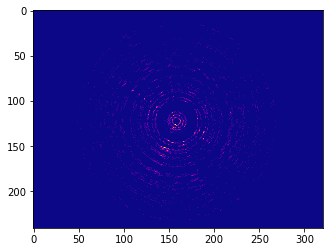

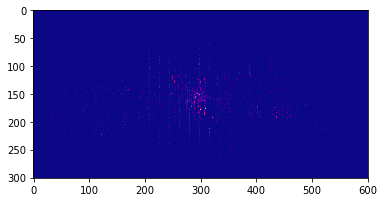

In [26]:
c = collisions.take(1)[0]
# Obtain the front feature matrix, exclude background hits.
m_f = construct_feature_matrix_front(c['tracks'], background=False)
m_s = construct_feature_matrix_side(c['tracks'], background=False)
# Plot the matrices.
plot_matrix(m_f)
plot_matrix(m_s)

In [33]:
def construct_feature_matrices(collision):
    # Obtain the tracks from the collision.
    tracks = collision['tracks']
    # Obtain the collision id.
    collision_id = collision['id']
    # Construct the front and side feature matrices.
    m_f = construct_feature_matrix_front(tracks, background=False)
    m_s = construct_feature_matrix_side(tracks, background=False)
    
    return Row(**{'collision_id': collision_id, 'front': m_f.tolist(), 'side': m_s.tolist()})

feature_matrices = collisions.map(construct_feature_matrices).toDF()
feature_matrices.printSchema()
feature_matrices.write.format("com.databricks.spark.avro").save("data/collisions_feature_matrices.avro")

root
 |-- collision_id: string (nullable = true)
 |-- front: array (nullable = true)
 |    |-- element: array (containsNull = true)
 |    |    |-- element: double (containsNull = true)
 |-- side: array (nullable = true)
 |    |-- element: array (containsNull = true)
 |    |    |-- element: double (containsNull = true)



Nevertheless, most machine learning problems have a better convergence rate when the data is normalized. This is because they in such cases don't have to deal (and correct) for large values. As a result, we perform normalization of our feature matrices as well. All feature matrices will be normalized within the range [0,1].

Furthermore, the way we apply normalization to these feature matrices is also important. In the case of images, normalization is quite trivial since the pixel-sensor's maximum value is constrainted by 255 (0xff). However, this is not the case in our problem. Multiple particle tracks can pass through a single part of the detector at the same time. An initial approach would be to normalize the data with respect to the maximum value of a matrix. But this would give a "wrong impression" to the classifier / regressor since in low-saturated vs highly-saturated environments this would mean that they have the same importance, while this is truly not the case. An additonal approach would be to obtain the max value over all matrices (with some additonal margin), and normalize the matrices with respect to that value. But then again, then we *assume* some maximum. Personally, I would go with the latter approach in this particular case.

In [44]:
def feature_matrix_max(row):
    # Obtain the feature matrices.
    m_f = np.asarray(row['front'])
    m_s = np.asarray(row['side'])
    # Obtain the max value of all feature matrices.
    max_f = float(m_f.max())
    max_s = float(m_s.max())
    
    return Row(**{"max_front": max_f, "max_side": max_s})
    

features_max = feature_matrices.map(feature_matrix_max).toDF()
max = features_max.agg({"max_front": "max", "max_side": "max"}).collect()[0]

max_front = max['max(max_front)']
max_side = max['max(max_side)']

print("Maximum of the front feature matrix: " + str(max_front))
print("Maximum of the side feature matrix: " + str(max_side))

Maximum of the front feature matrix: 170.0
Maximum of the side feature matrix: 139.0


From this we can safely assume (with some margin) that we can normalize the feature matrices by 200. So every pixel in the feature matrix will be normalized with respect to 200.

In [45]:
def normalize(row):
    # Obtain the collision id.
    collision_id = row['collision_id']
    # Set the normalizer.
    normalizer = 200.0
    # Obtain the feature matrices.
    m_f = np.asarray(row['front'])
    m_s = np.asarray(row['side'])
    # Normalize the feature matrices.
    m_f = np.divide(m_f, normalizer)
    m_s = np.divide(m_s, normalizer)
    
    return Row(**{'collision_id': collision_id, 'front': m_f.tolist(), 'side': m_s.tolist()})

feature_matrices_normalized = feature_matrices.map(normalize).toDF()
feature_matrices_normalized.write.format("com.databricks.spark.avro") \
                           .save("data/collisions_feature_matrices_normalized.avro")

However, other techniques apply batch normalization. This basically means that you normalize the instance with respect to a batch of figures. Nevertheless, in our case the batch size is 1. This implies that we normalize the instances with respect to their maximum.

In [8]:
def normalize(row):
    # Obtain the collision id.
    collision_id = row['collision_id']
    # Obtain the feature matrices.
    m_f = np.asarray(row['front'])
    m_s = np.asarray(row['side'])
    # Obtain the max of both feature matrices.
    max_f = m_f.max()
    max_s = m_s.max()
    # Normalize the feature matrices.
    m_f = np.divide(m_f, max_f)
    m_s = np.divide(m_s, max_s)
    
    return Row(**{'collision_id': collision_id, 'front': m_f.tolist(), 'side': m_s.tolist()})

feature_matrices_batch_normalized = feature_matrices.map(normalize).toDF()
feature_matrices_batch_normalized.write.format("com.databricks.spark.avro") \
                                 .save("data/collisions_feature_matrices_batch_normalized.avro")